# Combined BraTS 2020 Google Colab Notebook

## 1. Data Preparation (232_brats2020_get_data_ready.py)

In [1]:
!pip install segmentation-models-3D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0


In [3]:
import numpy as np
import nibabel as nib
import pandas as pd
import random
import glob
import matplotlib.pyplot as plt
import os
import segmentation_models_3D as sm
from tensorflow.keras.utils import to_categorical
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras.models import load_model

Segmentation Models: using `keras` framework.


In [4]:
scaler = MinMaxScaler()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define the path to the dataset in Google Drive
base_path = '/content/drive/My Drive/BraTS2021/'
training_dataset_path = (base_path + 'BraTS2021_Training_Data/')
training_example = (training_dataset_path + '/BraTS2021_01135')

In [7]:
test_image_flair=nib.load(training_example + '/BraTS2021_01135_flair.nii.gz').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape.
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(training_example + '/BraTS2021_01135_t1.nii.gz').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(training_example + '/BraTS2021_01135_t1ce.nii.gz').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(training_example + '/BraTS2021_01135_t2.nii.gz').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(training_example + '/BraTS2021_01135_seg.nii.gz').get_fdata()
test_mask=test_mask.astype(np.uint8)

1087.0


In [8]:
print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))

[0 1 2 4]
[0 1 2 3]


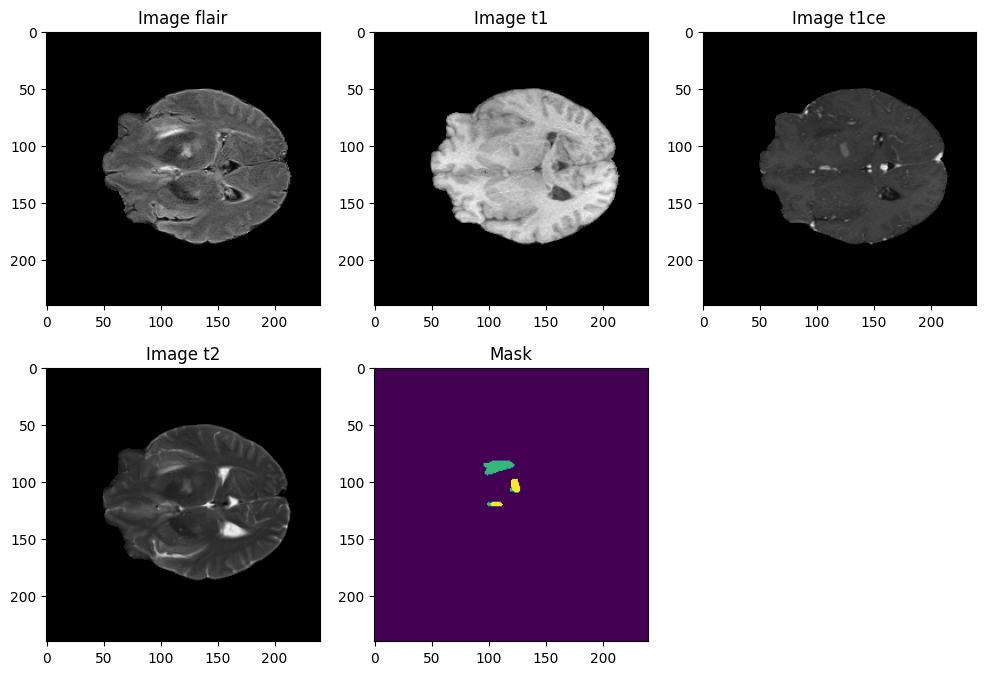

In [9]:
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [10]:
##################################################
#PART 2: Explore the process of combining images to channels and divide them to patches
#Includes...
#Combining all 4 images to 4 channels of a numpy array.
#
################################################
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

-----------------------------------------------

In [11]:
# Apply cropping
combined_x=combined_x[24:216, 24:216, 16:208]
test_mask = test_mask[24:216, 24:216, 16:208]

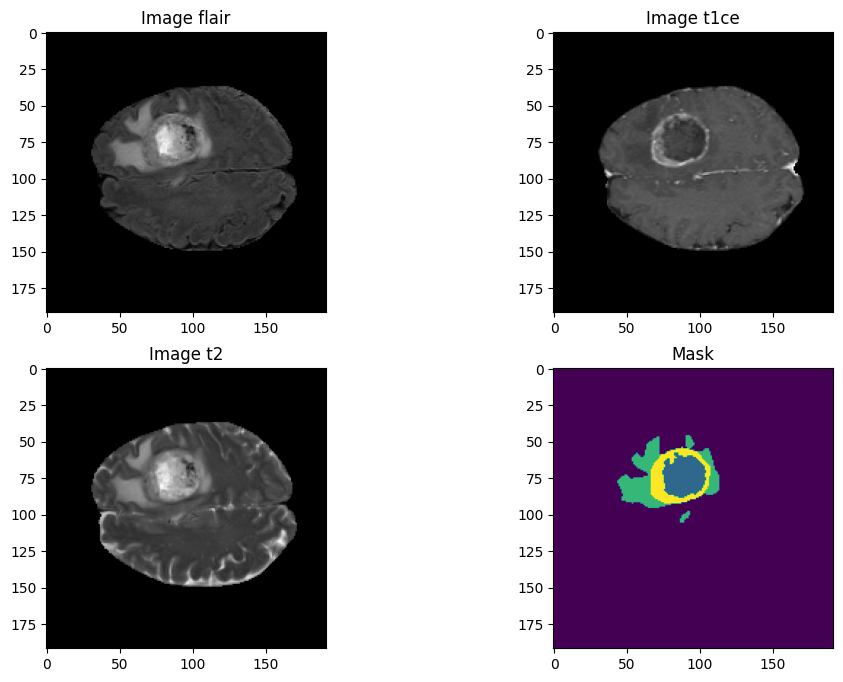

In [12]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

--------------------

In [13]:
imsave('./combined255.tif', combined_x)
np.save('./combined255.npy', combined_x)

<ipython-input-13-1311243473e9>:1: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('./combined255.tif', combined_x)


In [14]:
#Verify image is being read properly
#my_img=imread('BraTS2020_TrainingData/combined255.tif')

my_img=np.load('./combined255.npy')

test_mask = to_categorical(test_mask, num_classes=4)

 - RUN ONCE

In [16]:
#End of understanding the dataset. Now get it organized.
#####################################

#Now let us apply the same as above to all the images...
#Merge channels, crop, patchify, save
#GET DATA READY =  GENERATORS OR OTHERWISE

#Keras datagenerator does ntot support 3d

# # # images lists harley
#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob(training_dataset_path + '/*/*t2.nii.gz'))
t1ce_list = sorted(glob.glob(training_dataset_path + '/*/*t1ce.nii.gz'))
flair_list = sorted(glob.glob(training_dataset_path + '/*/*flair.nii.gz'))
mask_list = sorted(glob.glob(training_dataset_path + '/*/*seg.nii.gz'))

 - RUN ONCE

In [21]:
#Each volume generates 18 64x64x64x4 sub-volumes.
#Total 369 volumes = 6642 sub volumes
for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)

    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))

    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches.
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save(base_path + 'Training_Pot/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save(base_path + 'Training_Pot/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)

    else:
        print("I am useless")

Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
Save Me
Now preparing image and masks number:  5
I am useless
Now preparing image and masks number:  6
I am useless
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19
Save Me


IndexError: list index out of range

 - RUN ONCE

In [20]:
import os
import shutil
import random

# Paths
input_folder = '/content/drive/My Drive/BraTS2021/Training_Pot/input_data_3channels/'
output_folder = '/content/drive/My Drive/BraTS2021/Training_Pot/input_data_128/'

# Input subfolders
images_folder = os.path.join(input_folder, 'images')
masks_folder = os.path.join(input_folder, 'masks')

# Output subfolders
train_images_folder = os.path.join(output_folder, 'train', 'images')
train_masks_folder = os.path.join(output_folder, 'train', 'masks')
val_images_folder = os.path.join(output_folder, 'validation', 'images')
val_masks_folder = os.path.join(output_folder, 'validation', 'masks')

# Ensure output folder structure exists
os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(train_masks_folder, exist_ok=True)
os.makedirs(val_images_folder, exist_ok=True)
os.makedirs(val_masks_folder, exist_ok=True)

# Get list of all files in the images folder
image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]

# Shuffle files for randomness
random.seed(42)
random.shuffle(image_files)

# Split files into training and validation sets
split_index = int(0.75 * len(image_files))  # 75% for training, 25% for validation
train_files = image_files[:split_index]
val_files = image_files[split_index:]

# Function to copy files in batches
def copy_files_in_batches(files, source_folder, dest_folder, mask_source_folder, mask_dest_folder, batch_size=5):
    for i in range(0, len(files), batch_size):
        batch = files[i:i+batch_size]
        for file in batch:
            # Copy image
            shutil.copy(os.path.join(source_folder, file), os.path.join(dest_folder, file))
            # Copy corresponding mask
            mask_file = file.replace('image_', 'mask_')  # Match mask naming convention
            shutil.copy(os.path.join(mask_source_folder, mask_file), os.path.join(mask_dest_folder, mask_file))

# Copy train files in batches
print("Copying training files...")
copy_files_in_batches(train_files, images_folder, train_images_folder, masks_folder, train_masks_folder, batch_size=5)

# Copy validation files in batches
print("Copying validation files...")
copy_files_in_batches(val_files, images_folder, val_images_folder, masks_folder, val_masks_folder, batch_size=5)

# Output summary
print(f"Total image files: {len(image_files)}")
print(f"Training files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Training images saved to: {train_images_folder}")
print(f"Training masks saved to: {train_masks_folder}")
print(f"Validation images saved to: {val_images_folder}")
print(f"Validation masks saved to: {val_masks_folder}")

Copying training files...
Copying validation files...
Total image files: 1150
Training files: 862
Validation files: 288
Training images saved to: /content/drive/My Drive/BraTS2021/Training_Pot/input_data_128/train/images
Training masks saved to: /content/drive/My Drive/BraTS2021/Training_Pot/input_data_128/train/masks
Validation images saved to: /content/drive/My Drive/BraTS2021/Training_Pot/input_data_128/validation/images
Validation masks saved to: /content/drive/My Drive/BraTS2021/Training_Pot/input_data_128/validation/masks


In [ ]:
# Output summary
print(f"Total image files: {len(image_files)}")
print(f"Training files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Training images saved to: {train_images_folder}")
print(f"Training masks saved to: {train_masks_folder}")
print(f"Validation images saved to: {val_images_folder}")
print(f"Validation masks saved to: {val_masks_folder}")

In [21]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):
            image = np.load(img_dir+image_name)
            images.append(image)
    images = np.array(images)
    return(images)

In [22]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)
    #keras needs the generator infinite, so we will use while true
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples
            batch_start += batch_size
            batch_end += batch_size

In [23]:
train_img_dir = (base_path + "Training_Pot/input_data_128/train/images/")
train_mask_dir = (base_path + "Training_Pot/input_data_128/train/masks/")
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

In [24]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

In [25]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

In [26]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

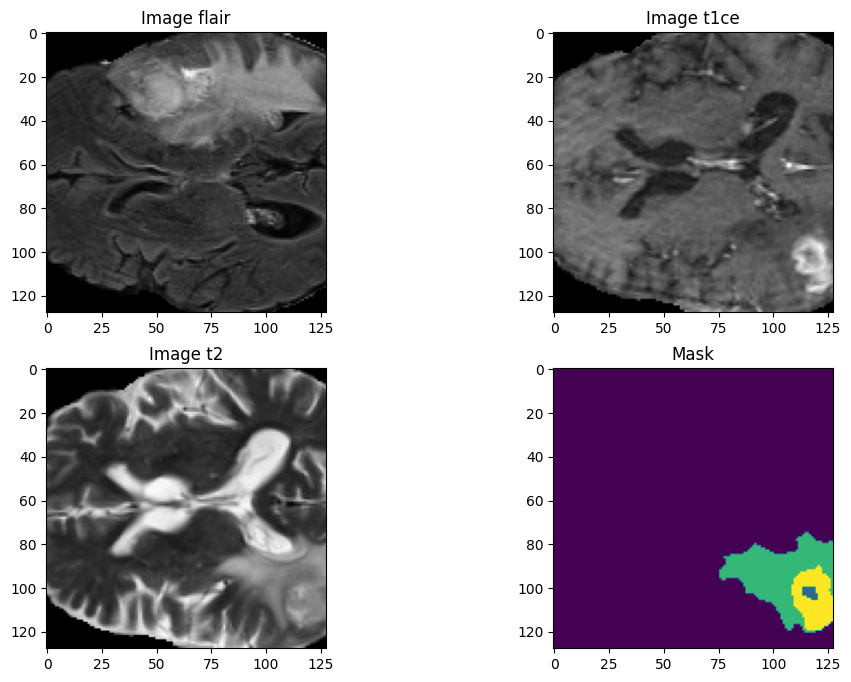

In [53]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

## 3. 3D U-Net Model (simple_3d_unet.py)

In [28]:
kernel_initializer =  'he_uniform' #Try others if you want

In [29]:

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()

    return model

#Test if everything is working ok.
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 128, 128, 128,  │          1,312 │ input_layer[0][0]      │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 128,  │              0 │ conv3d[0][0]           │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 128, 128, 128,  │          6,928 │ dropout[0][0]          │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 64, 64, 64, 16) │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64, 32) │              0 │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 64, 64, 64, 32) │         27,680 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 32, 32, 32, 32) │              0 │ conv3d_3[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 32, 64) │              0 │ conv3d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 32, 32, 32, 64) │        110,656 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 16, 16, 16, 64) │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_2[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 16,     │              0 │ conv3d_6[0][0]         │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


## 4. Training the Model (234_train_brats2020_V5.0.py)

In [30]:
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

**CHANGED FROM APPEND, MAY CAUSE ISSUE**

In [34]:
# Define columns and initialize the DataFrame
columns = ['0', '1', '2', '3']
df = pd.DataFrame(columns=columns)

train_mask_list = sorted(glob.glob(base_path + "Training_Pot/input_data_128/train/masks/*.npy"))
for img in range(len(train_mask_list)):
    print(img)
    temp_image = np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)

    # Create a dictionary for the row
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)

    # Convert the dictionary to a DataFrame and concatenate
    new_row = pd.DataFrame([conts_dict])
    df = pd.concat([df, new_row], ignore_index=True)

# Final DataFrame
print(df)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [55]:
label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4

In [56]:
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

In [57]:
print(wt0)
print(wt1)
print(wt2)
print(wt3)

0.26
31.38
31.38
23.62


 - Can be used for dice loss

In [37]:
val_img_dir = (base_path + "Training_Pot/input_data_128/validation/images/")
val_mask_dir = (base_path + "Training_Pot/input_data_128/validation/masks/")

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [38]:
train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

In [58]:
from tensorflow import keras

In [59]:
###########################################################################
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [45]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [46]:
model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_19 (Conv3D)        │ (None, 128, 128, 128,  │          1,312 │ input_layer_1[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128, 128, 128,  │              0 │ conv3d_19[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_20 (Conv3D)        │ (None, 128, 128, 128,  │          6,928 │ dropout_9[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_4           │ (None, 64, 64, 64, 16) │              0 │ conv3d_20[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_21 (Conv3D)        │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64, 64, 64, 32) │              0 │ conv3d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_22 (Conv3D)        │ (None, 64, 64, 64, 32) │         27,680 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 32, 32, 32, 32) │              0 │ conv3d_22[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_23 (Conv3D)        │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 32, 32, 32, 64) │              0 │ conv3d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_24 (Conv3D)        │ (None, 32, 32, 32, 64) │        110,656 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_6           │ (None, 16, 16, 16, 64) │              0 │ conv3d_24[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_25 (Conv3D)        │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_6[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 16, 16, 16,     │              0 │ conv3d_25[0][0]        │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_19 (Conv3D)        │ (None, 128, 128, 128,  │          1,312 │ input_layer_1[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128, 128, 128,  │              0 │ conv3d_19[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_20 (Conv3D)        │ (None, 128, 128, 128,  │          6,928 │ dropout_9[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_4           │ (None, 64, 64, 64, 16) │              0 │ conv3d_20[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_21 (Conv3D)        │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64, 64, 64, 32) │              0 │ conv3d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_22 (Conv3D)        │ (None, 64, 64, 64, 32) │         27,680 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 32, 32, 32, 32) │              0 │ conv3d_22[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_23 (Conv3D)        │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 32, 32, 32, 64) │              0 │ conv3d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_24 (Conv3D)        │ (None, 32, 32, 32, 64) │        110,656 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_6           │ (None, 16, 16, 16, 64) │              0 │ conv3d_24[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_25 (Conv3D)        │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_6[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 16, 16, 16,     │              0 │ conv3d_25[0][0]        │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [48]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/10


TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type float64 of argument 'x'.

In [ ]:
model.save('brats_3d.hdf5')

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

 ** CODE FALLS APART HERE**

In [ ]:
#Load model for prediction or continue training

#For continuing training....
#The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
#This is because the model does not save loss function and metrics. So to compile and
#continue training we need to provide these as custom_objects.
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5')

#So let us add

#So let us add the loss as custom object... but the following throws another error...
#Unknown metric function: iou_score
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss})

#Now, let us add the iou_score function we used during our initial training
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})


In [ ]:
#Now all set to continue the training process.
history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

In [ ]:
#For predictions you do not need to compile the model, so ...
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5',
                      compile=False)

In [ ]:
batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

In [ ]:
#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
img_num = 82

test_img = np.load(base_path + "Training_Pot/input_data_128/validation/images/image_"+str(img_num)+".npy")

test_mask = np.load(base_path + "Training_Pot/input_data_128/validation/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

In [ ]:

# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))



In [ ]:
#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()